In [1]:
import numpy as np
import os
import pickle
import csv
from scipy.special import softmax
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
from scipy import stats
import random
import pandas as pd

In [2]:
val_metadata_path = "/vision/asomaya1/ego_exo/data/demonstrator_arxiv24_test.json"
with open(val_metadata_path, "r") as f:
    val_data = json.load(f)

task_names = []
user_ids = []
for entry in val_data:
    task_names.append(entry['scenario_name'])
    user_ids.append(entry['origin_participant_id'])

is_v2 = True if "24" in val_metadata_path else False
is_val = True if "val" in val_metadata_path else False

In [3]:
camera_views = ['ego']
#options: 'ego', 'exo_all'
path_prefix = "/vision/asomaya1/ego_exo/ProficiencyEstimation/TimeSformer/outputs"

mode = "448pFull"
preds_file_name = "preds"
trained_on_v2 = True

if is_v2:
    mode += "_v2"
    if not trained_on_v2:
        preds_file_name += "_v2"
if is_val:
    preds_file_name = "val_" + preds_file_name
#options: 256p, 448p

kinetics_pretrain_path = "_K400_pretrain"
vlp_pretrain_path = "_vlp_pretrain"
vlpv2_pretrain_path = "_vlpv2_pretrain"
how_to_100m_pretrain_path = "_kinetics_pretrain" #NOTE: Not a typo, original was labeled incorrectly as kinetics
trained_on_v2_extension = "_v2_train"
#ONLY ONE OF THE BELOW PRE-TRAIN OPTIONS CAN BE TRUE
use_kinetics_pretrain = False
use_vlp_pretrain = False
use_vlpv2_pretrain = True  
use_how_to_100m_pretrain = False

#Set multi-take flag
multi_take_eval = False

In [4]:
csv_file_path = os.path.join("/vision/asomaya1/ego_exo/ProficiencyEstimation/TimeSformer/ego_exo_splits", mode, "ego", "test.csv")

paths = []
labels = []

# Open the CSV file and read labels
with open(csv_file_path, "r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=" ")

    for row in csv_reader:
        path = row[0]
        second_string = row[1]
        second_integer = int(second_string)
        labels.append(second_integer)
        paths.append(path)

# Convert the list of labels to a NumPy array
labels = torch.tensor(np.array(labels, dtype=np.int32))

In [5]:
preds = []
for view in camera_views:
    if use_kinetics_pretrain:
        view += kinetics_pretrain_path
    elif use_vlp_pretrain:
        view += vlp_pretrain_path
    elif use_vlpv2_pretrain:
        view += vlpv2_pretrain_path
    elif use_how_to_100m_pretrain:
        view += how_to_100m_pretrain_path
    if trained_on_v2:
        view += trained_on_v2_extension
    trunc_mode = "448pFull" if is_v2 else mode #NOTE: This is done because we need to drop "_v2" extension for loading in predictions (as v2 preds were stored under v1 folders in outputs)
    with open(os.path.join(path_prefix, trunc_mode, view, preds_file_name + ".pkl"), "rb") as f:
        data = pickle.load(f)
        pred = data[1]
        if len(pred) != 768: #v1 test set: 617, v1 val set: 466, v2 test set: 768, v2 val set: 561
            prediction_sets = []
            # Split the tensor
            for i in range(4):
                prediction_sets.append(pred[i::4, :])
            #prediction_sets = np.split(pred, 4)
            for p in prediction_sets:
                preds.append(p)
        else:
            preds.append(pred)

In [6]:
#get ensembled predictions:
concat_preds = torch.stack(preds,dim=0)

In [7]:
if multi_take_eval:
    user_id_to_indices = {uid: [i for i, x in enumerate(user_ids) if x == uid] for uid in set(user_ids)}

    # Find the maximum number of examples per user
    max_examples_per_user = max(len(indices) for indices in user_id_to_indices.values())

    # Prepare to concatenate slices for each test set example
    example_tensors = []

    for example_index in range(concat_preds.shape[1]):
        uid = user_ids[example_index]
        example_indices = user_id_to_indices[uid]

        # Get the slices for this user ID
        slices = concat_preds[:, example_indices, :]

        # Pad if necessary
        while slices.shape[1] < max_examples_per_user:
            slices = torch.cat((slices, slices[:, 0, :].unsqueeze(1)), dim=1)

        # Concatenate the slice for the current example
        reshaped_slice = slices.view(-1, 1, 4)
        #example_tensor = torch.cat((slices, concat_preds[:, example_index:example_index + 1, :]), dim=1)
        example_tensors.append(reshaped_slice)

    # Stack to form the final tensor
    concat_preds = torch.cat(example_tensors, dim=1)  # (new_first_dim, 365, 4)

In [8]:
softmax_preds = torch.nn.functional.softmax(concat_preds, dim=-1)
ensemble_preds = torch.mean(softmax_preds, dim=0)
pred_idxs = torch.argmax(ensemble_preds, dim=1)

In [9]:
#random baseline predictions:
num_examples = len(pred_idxs)
num_classes = 4

all_predictions = []

random_seeds = [random.randint(1, 1000) for _ in range(5)]
for seed in random_seeds:
    torch.manual_seed(seed)
    seed_predictions = torch.randint(0, num_classes, pred_idxs.shape)
    all_predictions.append(seed_predictions)

stacked_predictions = torch.stack(all_predictions)

random_baseline_preds = torch.tensor(stats.mode(stacked_predictions, axis=0).mode[0])

/tmp/ipykernel_3364365/1537972704.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  random_baseline_preds = torch.tensor(stats.mode(stacked_predictions, axis=0).mode[0])


In [10]:
baseline_mapping_filename = "majority_class_baseline_mapping_full"
if is_v2:
    baseline_mapping_filename += "_v2"
if is_val:
    baseline_mapping_filename = "val_" + baseline_mapping_filename
#class majority baseline predictions:
with open('/vision/asomaya1/ego_exo/ProficiencyEstimation/TimeSformer/ego_exo_splits/' + baseline_mapping_filename + '.json', 'r') as json_file:
    loaded_video_path_mapping = json.load(json_file)

class_majority_baseline_preds = []

with open(csv_file_path, "r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=" ")

    for row in csv_reader:
        video_path = row[0].replace("takes_"+mode, "takes")
        if is_v2:
            video_path = "takes/" + video_path
        mode_index = loaded_video_path_mapping[video_path]
        class_majority_baseline_preds.append(mode_index)

class_majority_baseline_preds = torch.tensor(np.array(class_majority_baseline_preds, dtype=np.int32))

In [11]:
correct_predictions = torch.sum(class_majority_baseline_preds == labels).item()
top1_accuracy = correct_predictions / len(labels)
print("Class majority baseline:")
print("top1 accuracy:", round(top1_accuracy,9))

Class majority baseline:
top1 accuracy: 0.424479167


In [12]:
#overall accuracy stats:
correct_predictions = torch.sum(pred_idxs == labels).item()
top1_accuracy = correct_predictions / len(labels)
print("Model:")
print("top1 accuracy:", round(top1_accuracy,9))

correct_predictions = torch.sum(random_baseline_preds == labels).item()
top1_accuracy = correct_predictions / len(labels)
print("Random baseline:")
print("top1 accuracy:", round(top1_accuracy,9))

correct_predictions = torch.sum(class_majority_baseline_preds == labels).item()
top1_accuracy = correct_predictions / len(labels)
print("Class majority baseline:")
print("top1 accuracy:", round(top1_accuracy,9))

Model:
top1 accuracy: 0.483072917
Random baseline:
top1 accuracy: 0.234375
Class majority baseline:
top1 accuracy: 0.424479167


In [13]:
#task-stratified accuracy stats: TIMESFORMER MODEL
import pandas as pd

# Create a DataFrame
data = {
    "Task": task_names,
    "TrueProficiency": labels,
    "PredictedProficiency": pred_idxs
}
df = pd.DataFrame(data)

# Compute Overall Top-1 Accuracy
total_tasks = len(df)
correct_predictions = (df["TrueProficiency"] == df["PredictedProficiency"]).sum()
overall_top1_accuracy = correct_predictions / total_tasks

# Compute Top-1 Accuracy for Each Task
task_grouped = df.groupby("Task")
task_accuracy = task_grouped.apply(lambda x: (x["TrueProficiency"] == x["PredictedProficiency"]).sum() / len(x))
task_count = task_grouped.apply(lambda x: len(x))
task_accuracy_df = task_accuracy.reset_index(name="TaskTop1Accuracy")

In [14]:
# Print the results
print("TIMESFORMER RESULTS:")
print("Overall Top-1 Accuracy:", overall_top1_accuracy)
print("Task-wise Top-1 Accuracy:")
task_accuracy_df

TIMESFORMER RESULTS:
Overall Top-1 Accuracy: 0.4830729166666667
Task-wise Top-1 Accuracy:


,Task,TaskTop1Accuracy
0,Basketball,0.461078
1,Cooking,0.279070
2,Dance,0.479730
3,Music,0.788732
4,Rock Climbing,0.378261
5,Soccer,0.848485


In [15]:
#task-stratified accuracy stats: MAJORITY BASELINE

# Create a DataFrame
data = {
    "Task": task_names,
    "TrueProficiency": labels,
    "PredictedProficiency": class_majority_baseline_preds
}
df = pd.DataFrame(data)

# Compute Overall Top-1 Accuracy
total_tasks = len(df)
correct_predictions = (df["TrueProficiency"] == df["PredictedProficiency"]).sum()
overall_top1_accuracy = correct_predictions / total_tasks

# Compute Top-1 Accuracy for Each Task
task_grouped = df.groupby("Task")
task_accuracy = task_grouped.apply(lambda x: (x["TrueProficiency"] == x["PredictedProficiency"]).sum() / len(x))
task_count = task_grouped.apply(lambda x: len(x))
task_accuracy_df = task_accuracy.reset_index(name="TaskTop1Accuracy")

In [16]:
df[df['Task']=="Rock Climbing"]['PredictedProficiency'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [17]:
df[df['Task']=="Rock Climbing"]['TrueProficiency'].values

array([2, 2, 1, 3, 0, 3, 2, 2, 2, 1, 3, 0, 2, 3, 2, 0, 0, 3, 1, 1, 0, 0,
       3, 3, 2, 2, 2, 3, 2, 2, 0, 1, 1, 2, 1, 1, 1, 2, 2, 0, 0, 2, 3, 2,
       0, 3, 3, 0, 2, 3, 2, 2, 3, 2, 0, 0, 1, 0, 1, 1, 3, 2, 2, 2, 2, 0,
       2, 2, 2, 3, 2, 0, 3, 2, 3, 2, 2, 3, 3, 2, 1, 0, 3, 3, 2, 2, 0, 3,
       2, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 3, 1, 1, 0, 1, 2, 0, 1, 2,
       3, 3, 3, 0, 3, 3, 1, 1, 1, 2, 1, 0, 1, 2, 2, 0, 3, 0, 3, 2, 1, 1,
       1, 2, 0, 2, 3, 3, 2, 3, 2, 2, 2, 0, 3, 1, 0, 2, 1, 2, 2, 3, 2, 1,
       2, 1, 1, 2, 3, 1, 2, 1, 0, 1, 1, 1, 1, 3, 0, 2, 1, 1, 0, 3, 2, 2,
       1, 3, 0, 2, 2, 1, 0, 3, 1, 0, 3, 0, 0, 0, 3, 3, 0, 3, 2, 2, 0, 1,
       2, 2, 0, 3, 3, 3, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 3, 0, 1, 3, 3,
       1, 0, 3, 3, 1, 1, 1, 2, 2, 1], dtype=int32)

In [18]:
print("MAJORITY CLASS BASELINE RESULTS:")
print("Overall Top-1 Accuracy:", overall_top1_accuracy)
print("Task-wise Top-1 Accuracy:")
task_accuracy_df

MAJORITY CLASS BASELINE RESULTS:
Overall Top-1 Accuracy: 0.4244791666666667
Task-wise Top-1 Accuracy:


,Task,TaskTop1Accuracy
0,Basketball,0.467066
1,Cooking,0.395349
2,Dance,0.466216
3,Music,0.732394
4,Rock Climbing,0.195652
5,Soccer,0.727273


In [19]:
task_count

Task
Basketball       167
Cooking           86
Dance            148
Music             71
Rock Climbing    230
Soccer            66
dtype: int64

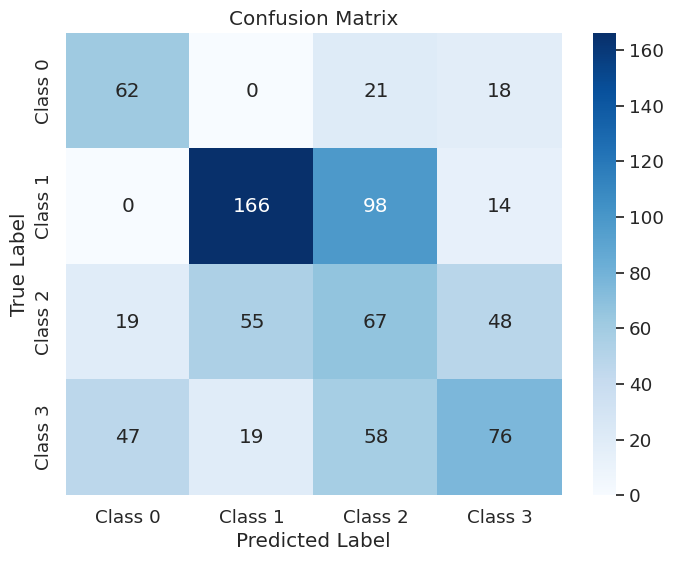

              precision    recall  f1-score   support

           0       0.48      0.61      0.54       101
           1       0.69      0.60      0.64       278
           2       0.27      0.35      0.31       189
           3       0.49      0.38      0.43       200

    accuracy                           0.48       768
   macro avg       0.48      0.49      0.48       768
weighted avg       0.51      0.48      0.49       768



In [20]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, pred_idxs)

# Calculate classification report with relevant metrics
report = classification_report(labels, pred_idxs)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print the classification report
print(report)